In [1]:
import pandas as pd

# Don't truncate columns or rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.width', 0)  # auto-adjust to screen size

# Then display your DataFrame
from IPython.display import display


In [8]:
import re
path = "/home/frozenwolf/Desktop/log_new.txt"
run_names_manual = ['BaselinePRM', 'token | Qwen2.5', 'clf | Qwen2.5', 'token | Qwen3', 'clf | Qwen3', 'trained | token | Qwen2.5', 'trained| clf | Qwen2.5']

import re

# Replace with your actual log input string or file read
with open(path) as f:
    log_text = f.read()

# 1. Extract all RUN names
run_names = re.findall(r"Running:\s*(.*)", log_text)

# 2. Extract all ProcessBench entries (dataset + accuracy)
processbench_entries = re.findall(
    r"Dataset:\s*(\w+).*?Problem-wise Metrics:\s*\{[^}]*?'Accuracy':\s*([0-9.]+)",
    log_text,
    re.DOTALL,
)


# 3. Extract all PRM step-wise & problem-wise accuracies
prm_stepwise_accuracies = re.findall(
    r"Step-wise Metrics:\s*\{[^}]*?'Accuracy':\s*([0-9.]+)", log_text
)
prm_problemwise_accuracies = re.findall(
    r"Step-wise Metrics: \{[^}]*?\}\s*Problem-wise Metrics:\s*\{[^}]*?'Accuracy':\s*([0-9.]+)",
    log_text
)

# 4. Extract all AIME entries (model_path, dataset, score)
aime_entries = re.findall(
    r"Model\s+(.*?)\s+on dataset\s+(.*?)\s+has score\s+([0-9.]+)", log_text
)

# # --- Display Results ---

# print("== RUN Names ==")
# for r in run_names:
#     print(r)

# print("\n== ProcessBench ==")
# for dataset, acc in processbench_entries:
#     print(f"{dataset}: {acc}")

# print("\n== PRM ==")
# print(f"Step-wise Accuracies: {prm_stepwise_accuracies}")
# print(f"Problem-wise Accuracies: {prm_problemwise_accuracies}")

# print("\n== AIME ==")
# for model, dataset, score in aime_entries:
#     model_name = model.split("/")[-1]
#     print(f"{dataset} | {model_name}: {score}")


from itertools import islice

# --- Group helpers ---
def chunked(iterable, size):
    it = iter(iterable)
    return list(iter(lambda: list(islice(it, size)), []))

# --- Grouped Entries ---
aime_groups = chunked(aime_entries, 6)
processbench_groups = chunked(processbench_entries, 4)
prm_stepwise = prm_stepwise_accuracies
prm_problemwise = prm_problemwise_accuracies

# --- Sanity Check ---
num_rows = min(len(aime_groups), len(processbench_groups), len(prm_stepwise))


import pandas as pd

# Create structured rows
table_rows = []
for i in range(num_rows):
    row = {}

    # --- AIME (flatten into columns like aime_1_dataset, aime_1_model, aime_1_score, ...)
    for j, (model, dataset, score) in enumerate(aime_groups[i], 1):
        model_name = model.split("/")[-1]
        row[f"AIME-{dataset}-{model_name}"] = float(score)

    # --- ProcessBench (math, olympiadbench, omnimath expected)
    for dataset, acc in processbench_groups[i]:
        row[f"processbench_{dataset.lower()}"] = float(acc)

    # --- PRM
    row["PRM800K_test_stepwise_acc"] = float(prm_stepwise[i])
    row["PRM800K_test_problemwise_acc"] = float(prm_problemwise[i])

    table_rows.append(row)

df = pd.DataFrame(table_rows)
run_names[0] = "trained token | Qwen2.5"
run_names[1] = "trained clf | Qwen2.5"
df.insert(0, "run name",run_names)
df


,run name,AIME-test2025-I-o4-mini,AIME-test2025-I-gemini,AIME-test2025-I-o4-mini-8-diverse,AIME-test2025-II-o4-mini,AIME-test2025-II-gemini,AIME-test2025-II-o4-mini-8-diverse,processbench_gsm8k,processbench_math,processbench_olympiadbench,processbench_omnimath,PRM800K_test_stepwise_acc,PRM800K_test_problemwise_acc
0,trained token | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5000,0.500,0.500,0.500,0.040227,0.578512
1,trained clf | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5000,0.500,0.500,0.500,0.959773,0.421488
2,token | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5000,0.500,0.500,0.500,0.040227,0.578512
3,clf | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5225,0.512,0.513,0.515,0.924355,0.421488
4,baseline,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.6525,0.680,0.614,0.589,0.930914,0.570248
5,clf | Qwen3,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5025,0.504,0.499,0.504,0.783559,0.396694


In [10]:
run_names

['trained token | Qwen2.5',
 'trained clf | Qwen2.5',
 'token | Qwen2.5',
 'clf | Qwen2.5',
 'baseline',
 'clf | Qwen3']

In [9]:
len(processbench_entries), len(prm_stepwise_accuracies), len(prm_problemwise_accuracies), len(aime_entries)

(24, 6, 6, 36)

In [ ]:
len(processbench_entries), len(aime_entries)

(33, 8, 8, 54)

In [3]:
df

,AIME-test2025-I-o4-mini,AIME-test2025-I-gemini,AIME-test2025-I-o4-mini-8-diverse,AIME-test2025-II-o4-mini,AIME-test2025-II-gemini,AIME-test2025-II-o4-mini-8-diverse,processbench_gsm8k,processbench_math,processbench_olympiadbench,processbench_omnimath,PRM800K_test_stepwise_acc,PRM800K_test_problemwise_acc
0,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5000,0.500,0.500,0.500,0.040227,0.578512
1,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5000,0.500,0.500,0.500,0.959773,0.421488
2,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5000,0.500,0.500,0.500,0.040227,0.578512
3,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5225,0.512,0.513,0.515,0.924355,0.421488
4,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.6525,0.680,0.614,0.589,0.930914,0.570248
5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.5025,0.504,0.499,0.504,0.783559,0.396694
6,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.7375,0.700,0.640,0.601,0.617840,0.247934
7,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.7575,0.700,0.651,NaN,0.678181,0.264463


In [4]:
run_names

['trained token | Qwen2.5',
 'trained clf | Qwen2.5',
 'token | Qwen2.5',
 'clf | Qwen2.5',
 'baseline',
 'clf | Qwen3',
 'qwen2.5-7B_clf_acc8_scratch_newtoken_whole-sky-243',
 'qwen2.5-7B_token_acc1_scratch_newtoken_leafy-morning-242',
 'qwen2.5-7B_clf_acc8_baseline_newtoken_silver-dawn-238']

In [ ]:
len(prm_problemwise_accuracies), len(prm_stepwise_accuracies), len(processbench_entries)

(6, 6, 24)

In [52]:
prm_problemwise_accuracies

['0.5785123966942148',
 '0.4214876033057851',
 '0.5785123966942148',
 '0.4214876033057851',
 '0.5702479338842975',
 '0.39669421487603307']

In [50]:
# AIME Table
aime_data = []
for group in aime_groups:
    row = {}
    for model, dataset, score in group:
        model_name = model.split("/")[-1]
        col_name = f"{dataset}_{model_name}"
        row[col_name] = float(score)
    aime_data.append(row)

df_aime = pd.DataFrame(aime_data)
df_aime.insert(0, 'run_names', run_names)
print("== AIME Table ==")
df_aime

== AIME Table ==


,run_names,test2025-I_o4-mini,test2025-I_gemini,test2025-I_o4-mini-8-diverse,test2025-II_o4-mini,test2025-II_gemini,test2025-II_o4-mini-8-diverse
0,trained token | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667
1,trained clf | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667
2,token | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667
3,clf | Qwen2.5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667
4,baseline,0.8,0.866667,0.733333,0.933333,0.866667,0.866667
5,clf | Qwen3,0.8,0.866667,0.733333,0.933333,0.866667,0.866667


In [38]:
import pandas as pd

# Step 1: Append model-level rows to df_aime
df_extra = pd.DataFrame({
    "run_names": [
        "model - pass@16",
        "model - pass@8",
        "model - consensus",
        "model - pass@1",
    ]
})

# Define mapping for easy access
model_scores = {
    "test2025-II_o4-mini": ["", "15/15 = 1.0000", "13/15 = 0.8667", "12.375/15 = 0.8250"],
    "test2025-II_o4-mini-8-diverse": ["", "15/15 = 1.0000", "14/15 = 0.9333", "13.375/15 = 0.8917"],
    "test2025-II_gemini": ["14/15 = 0.9333", "13.9872/15 = 0.9325", "13/15 = 0.8667", "13.0625/15 = 0.8708"],
    "test2025-I_o4-mini": ["", "14/15 = 0.9333", "13/15 = 0.8667", "11.75/15 = 0.7833"],
    "test2025-I_o4-mini-8-diverse": ["", "13/15 = 0.8667", "13/15 = 0.8667", "10.875/15 = 0.7250"],
    "test2025-I_gemini": ["14/15 = 0.9333", "13.9580/15 = 0.9305", "12/15 = 0.8000", "12.5/15 = 0.8333"],
}

# Append each metric row
for i in range(4):  # 4 metrics
    row = {k: v[i] for k, v in model_scores.items()}
    df_extra.loc[i, list(row.keys())] = list(row.values())

# Combine original + new rows
df_aime_with_extra = pd.concat([df_aime, df_extra], ignore_index=True)

# Step 2: Convert to MultiIndex
run_names = df_aime_with_extra['run_names']
df_temp = df_aime_with_extra.drop(columns=['run_names'])

multi_cols = []
for col in df_temp.columns:
    if col.startswith("test2025-II"):
        group = "test2025-II"
    elif col.startswith("test2025-I"):
        group = "test2025-I"
    else:
        group = "Other"
    model = col.split("_")[-1]
    multi_cols.append((group, model))

df_temp.columns = pd.MultiIndex.from_tuples(multi_cols)
df_temp.insert(0, ('', 'run_names'), run_names)

# Final table
print("== Final AIME Table ==")
df_temp


== Final AIME Table ==


test2025-I                       \
                 run_names            o4-mini               gemini   
0  trained token | Qwen2.5                0.8             0.866667   
1    trained clf | Qwen2.5                0.8             0.866667   
2          token | Qwen2.5                0.8             0.866667   
3            clf | Qwen2.5                0.8             0.866667   
4                 baseline                0.8             0.866667   
5              clf | Qwen3                0.8             0.866667   
6          model - pass@16                          14/15 = 0.9333   
7           model - pass@8     14/15 = 0.9333  13.9580/15 = 0.9305   
8        model - consensus     13/15 = 0.8667       12/15 = 0.8000   
9           model - pass@1  11.75/15 = 0.7833     12.5/15 = 0.8333   

                              test2025-II                       \
    o4-mini-8-diverse             o4-mini               gemini   
0            0.733333            0.933333             0.866667   
1            0.733333            0.933333             0.866667   
2            0.733333            0.933333             0.866667   
3            0.733333            0.933333             0.866667   
4            0.733333            0.933333             0.866667   
5            0.733333            0.933333             0.866667   
6                                               14/15 = 0.9333   
7      13/15 = 0.8667      15/15 = 1.0000  13.9872/15 = 0.9325   
8      13/15 = 0.8667      13/15 = 0.8667       13/15 = 0.8667   
9  10.875/15 = 0.7250  12.375/15 = 0.8250  13.0625/15 = 0.8708   

                       
    o4-mini-8-diverse  
0            0.866667  
1            0.866667  
2            0.866667  
3            0.866667  
4            0.866667  
5            0.866667  
6                      
7      15/15 = 1.0000  
8      14/15 = 0.9333  
9  13.375/15 = 0.8917

In [54]:
# Extract all full PRM metrics
prm_stepwise_full = re.findall(
    r"Step-wise Metrics:\s*\{([^}]+)\}", log_text
)
prm_problemwise_full = re.findall(
    r"Step-wise Metrics:\s*\{[^}]*?\}\s*Problem-wise Metrics:\s*\{([^}]*)\}",
    log_text
)
# Extract all full ProcessBench metrics
processbench_full = re.findall(
    r"Dataset:\s*(\w+).*?Problem-wise Metrics:\s*\{([^}]+)\}",
    log_text,
    re.DOTALL,
)

import ast

# Parse PRM metrics
parsed_prm_stepwise = [ast.literal_eval("{" + entry + "}") for entry in prm_stepwise_full]
parsed_prm_problemwise = [ast.literal_eval("{" + entry + "}") for entry in prm_problemwise_full]

# Parse ProcessBench metrics
processbench_by_dataset = {}
for dataset, metrics_str in processbench_full:
    metrics = ast.literal_eval("{" + metrics_str + "}")
    if dataset not in processbench_by_dataset:
        processbench_by_dataset[dataset] = []
    processbench_by_dataset[dataset].append(metrics)


# Multi-indexed DataFrame: PRM
prm_rows = []
for sw, pw in zip(parsed_prm_stepwise, parsed_prm_problemwise):
    row = {
        ("stepwise", k): v for k, v in sw.items()
    }
    row.update({
        ("problemwise", k): v for k, v in pw.items()
    })
    prm_rows.append(row)

df_prm_full = pd.DataFrame(prm_rows)
df_prm_full.columns = pd.MultiIndex.from_tuples(df_prm_full.columns)
df_prm_full

df_prm_full.insert(0, 'run_names', run_names)
df_prm_full


run_names stepwise                                    \
                                 TP  FP  TN    FN  Accuracy Precision   
0  trained token | Qwen2.5        0   0  92  2195  0.040227  0.000000   
1    trained clf | Qwen2.5     2195  92   0     0  0.959773  0.959773   
2          token | Qwen2.5        0   0  92  2195  0.040227  0.000000   
3            clf | Qwen2.5     2080  58  34   115  0.924355  0.972872   
4                 baseline     2079  42  50   116  0.930914  0.980198   
5              clf | Qwen3     1784  84   8   411  0.783559  0.955032   

                      problemwise                                            \
     Recall        F1          TP  FP  TN  FN  Accuracy Precision    Recall   
0  0.000000  0.000000           0   0  70  51  0.578512  0.000000  0.000000   
1  1.000000  0.979473          51  70   0   0  0.421488  0.421488  1.000000   
2  0.000000  0.000000           0   0  70  51  0.578512  0.000000  0.000000   
3  0.947608  0.960074          51  70   0   0  0.421488  0.421488  1.000000   
4  0.947153  0.963392          32  33  37  19  0.570248  0.492308  0.627451   
5  0.812756  0.878169          46  68   2   5  0.396694  0.403509  0.901961   

             
         F1  
0  0.000000  
1  0.593023  
2  0.000000  
3  0.593023  
4  0.551724  
5  0.557576

In [40]:
# Multi-indexed DataFrame: ProcessBench
pb_rows = []
for i in range(len(next(iter(processbench_by_dataset.values())))):  # number of rows
    row = {}
    for dataset, metrics_list in processbench_by_dataset.items():
        if i < len(metrics_list):
            for k, v in metrics_list[i].items():
                row[(dataset, k)] = v
    pb_rows.append(row)

df_processbench_full = pd.DataFrame(pb_rows)
df_processbench_full.columns = pd.MultiIndex.from_tuples(df_processbench_full.columns)


df_processbench_full.insert(0, 'run_names', run_names)
df_processbench_full

run_names gsm8k                                           \
                              TP   FP   TN   FN Accuracy Precision Recall   
0  trained token | Qwen2.5     0    0  200  200   0.5000  0.000000  0.000   
1    trained clf | Qwen2.5   200  200    0    0   0.5000  0.500000  1.000   
2          token | Qwen2.5     0    0  200  200   0.5000  0.000000  0.000   
3            clf | Qwen2.5   200  191    9    0   0.5225  0.511509  1.000   
4                 baseline   199  138   62    1   0.6525  0.590504  0.995   
5              clf | Qwen3     4    3  197  196   0.5025  0.571429  0.020   

            math                                                     \
         F1   TP   FP   TN   FN Accuracy Precision Recall        F1   
0  0.000000    0    0  500  500    0.500  0.000000  0.000  0.000000   
1  0.666667  500  500    0    0    0.500  0.500000  1.000  0.666667   
2  0.000000    0    0  500  500    0.500  0.000000  0.000  0.000000   
3  0.676819  496  484   16    4    0.512  0.506122  0.992  0.670270   
4  0.741155  476  296  204   24    0.680  0.616580  0.952  0.748428   
5  0.038647   12    8  492  488    0.504  0.600000  0.024  0.046154   

  olympiadbench                                                    omnimath  \
             TP   FP   TN   FN Accuracy Precision Recall        F1       TP   
0             0    0  500  500    0.500  0.000000  0.000  0.000000        0   
1           500  500    0    0    0.500  0.500000  1.000  0.666667      500   
2             0    0  500  500    0.500  0.000000  0.000  0.000000        0   
3           492  479   21    8    0.513  0.506694  0.984  0.668933      486   
4           474  360  140   26    0.614  0.568345  0.948  0.710645      456   
5             0    1  499  500    0.499  0.000000  0.000  0.000000        6   

                                                      
    FP   TN   FN Accuracy Precision Recall        F1  
0    0  500  500    0.500  0.000000  0.000  0.000000  
1  500    0    0    0.500  0.500000  1.000  0.666667  
2    0  500  500    0.500  0.000000  0.000  0.000000  
3  471   29   14    0.515  0.507837  0.972  0.667124  
4  367  133   44    0.589  0.554070  0.912  0.689342  
5    2  498  494    0.504  0.750000  0.012  0.023622

In [19]:
all_metrics = [
    "TP",         # True Positives
    "FP",         # False Positives
    "TN",         # True Negatives
    "FN",         # False Negatives
    "Accuracy",   # Overall accuracy
    "Precision",  # Precision = TP / (TP + FP)
    "Recall",     # Recall = TP / (TP + FN)
    "F1"          # Harmonic mean of Precision and Recall
]

# Pick metrics to show
selected_metrics = [
    "TP",         # True Positives
    "FP",         # False Positives
    "TN",         # True Negatives
    "FN",         # False Negatives
    "Accuracy",   # Overall accuracy
    "F1"          # Harmonic mean of Precision and Recall
]



# Filter ProcessBench table
filtered_processbench = df_processbench_full.loc[:, df_processbench_full.columns.get_level_values(1).isin(selected_metrics)]



filtered_processbench.insert(0, 'run_names', run_names)

filtered_processbench

run_names gsm8k                                   math       \
                              TP   FP   TN   FN Accuracy        F1   TP   FP   
0  trained token | Qwen2.5     0    0  200  200   0.5000  0.000000    0    0   
1    trained clf | Qwen2.5   200  200    0    0   0.5000  0.666667  500  500   
2          token | Qwen2.5     0    0  200  200   0.5000  0.000000    0    0   
3            clf | Qwen2.5   200  191    9    0   0.5225  0.676819  496  484   
4                 baseline   199  138   62    1   0.6525  0.741155  476  296   
5              clf | Qwen3     4    3  197  196   0.5025  0.038647   12    8   

                               olympiadbench                          \
    TN   FN Accuracy        F1            TP   FP   TN   FN Accuracy   
0  500  500    0.500  0.000000             0    0  500  500    0.500   
1    0    0    0.500  0.666667           500  500    0    0    0.500   
2  500  500    0.500  0.000000             0    0  500  500    0.500   
3   16    4    0.512  0.670270           492  479   21    8    0.513   
4  204   24    0.680  0.748428           474  360  140   26    0.614   
5  492  488    0.504  0.046154             0    1  499  500    0.499   

            omnimath                                    
         F1       TP   FP   TN   FN Accuracy        F1  
0  0.000000        0    0  500  500    0.500  0.000000  
1  0.666667      500  500    0    0    0.500  0.666667  
2  0.000000        0    0  500  500    0.500  0.000000  
3  0.668933      486  471   29   14    0.515  0.667124  
4  0.710645      456  367  133   44    0.589  0.689342  
5  0.000000        6    2  498  494    0.504  0.023622

In [86]:
from itertools import islice

# --- Group helpers ---
def chunked(iterable, size):
    it = iter(iterable)
    return list(iter(lambda: list(islice(it, size)), []))

# --- Grouped Entries ---
aime_groups = chunked(aime_entries, 6)
processbench_groups = chunked(processbench_entries, 3)
prm_stepwise = prm_stepwise_accuracies
prm_problemwise = prm_problemwise_accuracies

# --- Sanity Check ---
num_rows = min(len(aime_groups), len(processbench_groups), len(prm_stepwise))

# --- Table Output ---
print("\n=== Combined Table ===")
for i in range(num_rows):
    print(f"\n--- Entry {i+1} ---")

    # AIME
    print("AIME:")
    for model, dataset, score in aime_groups[i]:
        model_name = model.split("/")[-1]
        print(f"  {dataset} | {model_name}: {score}")

    # ProcessBench
    print("ProcessBench:")
    for dataset, acc in processbench_groups[i]:
        print(f"  {dataset}: {acc}")

    # PRM
    print("PRM:")
    print(f"  Step-wise Accuracy: {prm_stepwise[i]}")
    print(f"  Problem-wise Accuracy: {prm_problemwise[i]}")



=== Combined Table ===

--- Entry 1 ---
AIME:
  test2025-I | o4-mini: 0.8
  test2025-I | gemini: 0.8666666666666667
  test2025-I | o4-mini-8-diverse: 0.7333333333333333
  test2025-II | o4-mini: 0.9333333333333333
  test2025-II | gemini: 0.8666666666666667
  test2025-II | o4-mini-8-diverse: 0.8666666666666667
ProcessBench:
  math: 0.68
  olympiadbench: 0.614
  omnimath: 0.589
PRM:
  Step-wise Accuracy: 0.9309138609532138
  Problem-wise Accuracy: 0.6525

--- Entry 2 ---
AIME:
  test2025-I | o4-mini: 0.8
  test2025-I | gemini: 0.8666666666666667
  test2025-I | o4-mini-8-diverse: 0.7333333333333333
  test2025-II | o4-mini: 0.9333333333333333
  test2025-II | gemini: 0.8666666666666667
  test2025-II | o4-mini-8-diverse: 0.8666666666666667
ProcessBench:
  math: 0.5
  olympiadbench: 0.5
  omnimath: 0.5
PRM:
  Step-wise Accuracy: 0.04022737210319195
  Problem-wise Accuracy: 0.68

--- Entry 3 ---
AIME:
  test2025-I | o4-mini: 0.8
  test2025-I | gemini: 0.8666666666666667
  test2025-I | o4-mini-

In [87]:
len(aime_entries), len(processbench_entries), len(prm_stepwise_accuracies), len(prm_problemwise_accuracies)

(42, 21, 7, 35)

In [81]:
len(aime_entries), len(processbench_entries), len(prm_stepwise_accuracies), len(prm_problemwise_accuracies)

(42, 21, 7, 35)

In [88]:
import pandas as pd

# Create structured rows
table_rows = []
for i in range(num_rows):
    row = {}

    # --- AIME (flatten into columns like aime_1_dataset, aime_1_model, aime_1_score, ...)
    for j, (model, dataset, score) in enumerate(aime_groups[i], 1):
        model_name = model.split("/")[-1]
        row[f"AIME-{dataset}-{model_name}"] = float(score)

    # --- ProcessBench (math, olympiadbench, omnimath expected)
    for dataset, acc in processbench_groups[i]:
        row[f"processbench_{dataset.lower()}"] = float(acc)

    # --- PRM
    row["PRM800K_test_stepwise_acc"] = float(prm_stepwise[i])
    row["PRM800K_test_problemwise_acc"] = float(prm_problemwise[i])

    table_rows.append(row)

# Create DataFrame
df = pd.DataFrame(table_rows)
df

,AIME-test2025-I-o4-mini,AIME-test2025-I-gemini,AIME-test2025-I-o4-mini-8-diverse,AIME-test2025-II-o4-mini,AIME-test2025-II-gemini,AIME-test2025-II-o4-mini-8-diverse,processbench_math,processbench_olympiadbench,processbench_omnimath,PRM800K_test_stepwise_acc,PRM800K_test_problemwise_acc
0,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.680,0.614,0.589,0.930914,0.652500
1,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.500,0.500,0.500,0.040227,0.680000
2,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.526,0.531,0.519,0.899432,0.614000
3,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.500,0.500,0.500,0.040227,0.589000
4,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.501,0.501,0.500,0.591605,0.570248
5,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.500,0.500,0.500,0.040227,0.500000
6,0.8,0.866667,0.733333,0.933333,0.866667,0.866667,0.500,0.500,0.500,0.959773,0.500000


In [89]:
run_names

['BaselinePRM',
 'BaselinePRM',
 'BaselinePRM',
 'proocessbench_myprm_qwen_benchmark.py | token | Qwen2.5',
 'myprm_qwen_benchmark.py | token | Qwen2.5',
 'aime_myprm_benchmark.py | token | Qwen2.5',
 'aime_myprm_benchmark.py | clf | Qwen2.5',
 'myprm_qwen_benchmark.py | clf | Qwen2.5',
 'proocessbench_myprm_qwen_benchmark.py | clf | Qwen2.5',
 'aime_myprm_benchmark.py | token | Qwen3',
 'myprm_qwen_benchmark.py | token | Qwen3',
 'proocessbench_myprm_qwen_benchmark.py | token | Qwen3',
 'aime_myprm_benchmark.py | clf | Qwen3',
 'myprm_qwen_benchmark.py | clf | Qwen3',
 'proocessbench_myprm_qwen_benchmark.py | clf | Qwen3',
 'qwen2.5-7B_token_acc16_baseline_lr1e-4_dropout0',
 'qwen2.5-7B_clf_acc8_baseline_lr1e-4_dropout0']

In [90]:
import pandas as pd

table_rows = []
run_names = ['BaselinePRM', 'token | Qwen2.5', 'clf | Qwen2.5', 'token | Qwen3', 'clf | Qwen3', 'trained | token | Qwen2.5', 'trained| clf | Qwen2.5']

for i in range(num_rows):
    row = {}
    # AIME
    for j, (model, dataset, score) in enumerate(aime_groups[i], 1):
        model_name = model.split("/")[-1]
        row[("AIME", f"{dataset}_{model_name}")] = float(score)

    # ProcessBench
    for dataset, acc in processbench_groups[i]:
        row[("ProcessBench", dataset.lower())] = float(acc)

    # PRM800K
    row[("PRM800K", "stepwise_acc")] = float(prm_stepwise[i])
    row[("PRM800K", "problemwise_acc")] = float(prm_problemwise[i])

    table_rows.append(row)

# Create MultiIndex DataFrame
df = pd.DataFrame(table_rows)
df.columns = pd.MultiIndex.from_tuples(df.columns)

# Optional: Pretty display
df = df.sort_index(axis=1, level=0)
df


AIME                                                    \
  test2025-II_gemini test2025-II_o4-mini test2025-II_o4-mini-8-diverse   
0           0.866667            0.933333                      0.866667   
1           0.866667            0.933333                      0.866667   
2           0.866667            0.933333                      0.866667   
3           0.866667            0.933333                      0.866667   
4           0.866667            0.933333                      0.866667   
5           0.866667            0.933333                      0.866667   
6           0.866667            0.933333                      0.866667   

                                                                     \
  test2025-I_gemini test2025-I_o4-mini test2025-I_o4-mini-8-diverse   
0          0.866667                0.8                     0.733333   
1          0.866667                0.8                     0.733333   
2          0.866667                0.8                     0.733333   
3          0.866667                0.8                     0.733333   
4          0.866667                0.8                     0.733333   
5          0.866667                0.8                     0.733333   
6          0.866667                0.8                     0.733333   

          PRM800K              ProcessBench                         
  problemwise_acc stepwise_acc         math olympiadbench omnimath  
0        0.652500     0.930914        0.680         0.614    0.589  
1        0.680000     0.040227        0.500         0.500    0.500  
2        0.614000     0.899432        0.526         0.531    0.519  
3        0.589000     0.040227        0.500         0.500    0.500  
4        0.570248     0.591605        0.501         0.501    0.500  
5        0.500000     0.040227        0.500         0.500    0.500  
6        0.500000     0.959773        0.500         0.500    0.500

In [91]:
df.insert(0, 'run_names', run_names)
df

run_names               AIME                      \
                             test2025-II_gemini test2025-II_o4-mini   
0                BaselinePRM           0.866667            0.933333   
1            token | Qwen2.5           0.866667            0.933333   
2              clf | Qwen2.5           0.866667            0.933333   
3              token | Qwen3           0.866667            0.933333   
4                clf | Qwen3           0.866667            0.933333   
5  trained | token | Qwen2.5           0.866667            0.933333   
6     trained| clf | Qwen2.5           0.866667            0.933333   

                                                                      \
  test2025-II_o4-mini-8-diverse test2025-I_gemini test2025-I_o4-mini   
0                      0.866667          0.866667                0.8   
1                      0.866667          0.866667                0.8   
2                      0.866667          0.866667                0.8   
3                      0.866667          0.866667                0.8   
4                      0.866667          0.866667                0.8   
5                      0.866667          0.866667                0.8   
6                      0.866667          0.866667                0.8   

                                       PRM800K              ProcessBench  \
  test2025-I_o4-mini-8-diverse problemwise_acc stepwise_acc         math   
0                     0.733333        0.652500     0.930914        0.680   
1                     0.733333        0.680000     0.040227        0.500   
2                     0.733333        0.614000     0.899432        0.526   
3                     0.733333        0.589000     0.040227        0.500   
4                     0.733333        0.570248     0.591605        0.501   
5                     0.733333        0.500000     0.040227        0.500   
6                     0.733333        0.500000     0.959773        0.500   

                          
  olympiadbench omnimath  
0         0.614    0.589  
1         0.500    0.500  
2         0.531    0.519  
3         0.500    0.500  
4         0.501    0.500  
5         0.500    0.500  
6         0.500    0.500

In [5]:
from datasets import load_dataset, load_from_disk
ds = load_from_disk("../PRM800k_cleaned")

In [6]:
df = ds['train'].to_pandas()
df

,prompt,completions,labels,index,correctness,answer,subject,level,__index_level_0__
0,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,0
1,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,1
2,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,2
3,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,3
4,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,4
...,...,...,...,...,...,...,...,...,...
326762,Find the greatest common divisor of 12 and 20.,"[To find the greatest common divisor, we need ...",[False],97732,0,4,Prealgebra,2,327693
326763,Find the greatest common divisor of 12 and 20.,[Let's write out the prime factorization of 12.],[True],97732,0,4,Prealgebra,2,327694
326764,Find the greatest common divisor of 12 and 20.,[Let's write the prime factorization for each ...,[True],97732,0,4,Prealgebra,2,327695
326765,Find the greatest common divisor of 12 and 20.,[Let's prime factorize 12. 12 is divisible by ...,[True],97732,0,4,Prealgebra,2,327696


In [7]:
### labels column is a list of bools. add them and count
count = df['labels'].apply(lambda x: sum(x))
total = df['labels'].apply(lambda x: len(x))
positive_perc = count / total * 100
positive_perc = positive_perc.to_list()
from collections import Counter
counter = Counter(positive_perc)

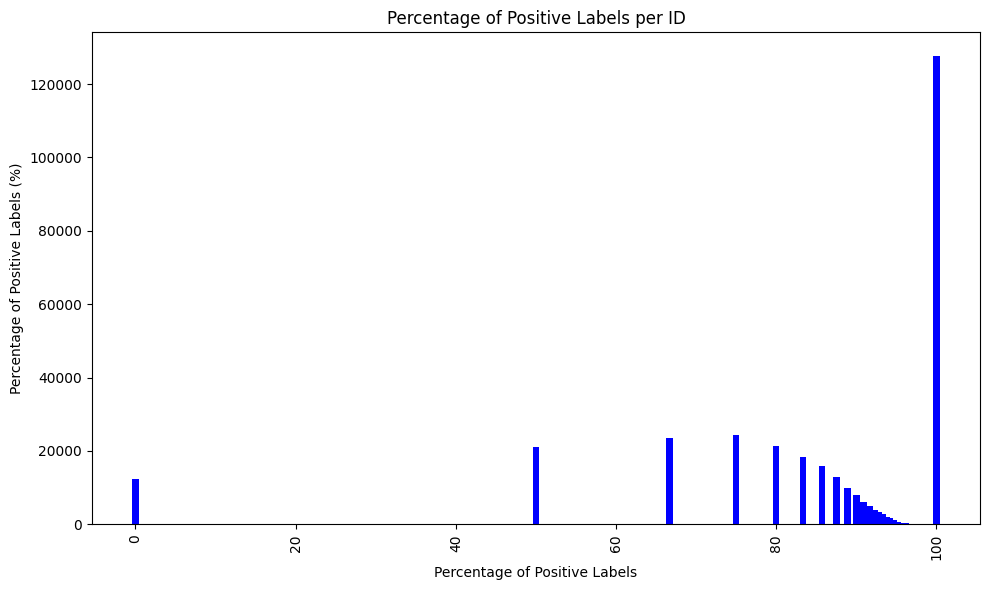

In [8]:

### plot matplotlib counter
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(counter.keys(), counter.values(), color='blue')
plt.xlabel('Percentage of Positive Labels')
plt.ylabel('Percentage of Positive Labels (%)')
plt.title('Percentage of Positive Labels per ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
sum(positive_perc)/len(positive_perc)

84.05077349052932

In [12]:
sum(count.to_list()) / sum(total.to_list()) * 100

89.90428285170461

In [12]:

dst = ds['test'].to_pandas()
dst

,prompt,completions,labels,index,correctness,answer,subject,level,__index_level_0__
0,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2,0
1,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2,1
2,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2,2
3,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2,3
4,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2,4
...,...,...,...,...,...,...,...,...,...
9876,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, False]",2710,0,"(2,4)",Geometry,2,9951
9877,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, True]",2710,0,"(2,4)",Geometry,2,9952
9878,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, False]",2710,0,"(2,4)",Geometry,2,9953
9879,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, False]",2710,0,"(2,4)",Geometry,2,9954


In [13]:
dst['subject'].value_counts()

subject
Algebra                   2399
Intermediate Algebra      2361
Number Theory             1437
Prealgebra                1258
Precalculus               1069
Counting & Probability     743
Geometry                   614
Name: count, dtype: int64

In [14]:
import pandas as pd
def select_top_20(group):
    # Ensure label length is available
    group = group.copy()
    group['label_len'] = group['labels'].apply(len)
    
    # Get top 10 True correctness with unique prompts
    true_rows = (
        group[group['correctness'] == True]
        .sort_values('label_len', ascending=False)
        .drop_duplicates('prompt')
        .head(10)
    )

    # Get top 10 False correctness with unique prompts
    false_rows = (
        group[group['correctness'] == False]
        .sort_values('label_len', ascending=False)
        .drop_duplicates('prompt')
        .head(10)
    )
    
    return pd.concat([true_rows, false_rows])

# Apply this for each subject
dst_selected = dst.groupby('subject', group_keys=False).apply(select_top_20)

# Optional cleanup
dst_selected = dst_selected.drop(columns='label_len').reset_index(drop=True)


In [17]:
dst_selected['subject'].value_counts()

subject
Algebra                   20
Intermediate Algebra      20
Number Theory             19
Counting & Probability    18
Precalculus               18
Geometry                  14
Prealgebra                12
Name: count, dtype: int64

In [18]:
dst['subject']

0        Algebra
1        Algebra
2        Algebra
3        Algebra
4        Algebra
          ...   
9876    Geometry
9877    Geometry
9878    Geometry
9879    Geometry
9880    Geometry
Name: subject, Length: 9881, dtype: object

In [19]:
dst['correctness'].value_counts()

correctness
0    9523
1     358
Name: count, dtype: int64

In [6]:
import torch
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F


def make_step_rewards(logits, token_masks):
    probabilities = F.softmax(logits, dim=-1)
    probabilities = probabilities * token_masks.unsqueeze(-1)  # bs, seq_len, num_labels

    all_scores_res = []
    for i in range(probabilities.size(0)):
        sample = probabilities[i]  # seq_len, num_labels
        positive_probs = sample[sample != 0].view(-1, 2)[:, 1]  # get p(label=1)
        all_scores_res.append(positive_probs.cpu().tolist())
    return all_scores_res


def evaluate_question_stepwise(model, tokenizer, system_prompt, question, stepwise_solution):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
        {"role": "assistant", "content": "<extra_0>".join(stepwise_solution) + "<extra_0>"},
    ]
    conversation_str = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False
    )
    
    # print("Conversation String:", conversation_str)
    
    input_ids = tokenizer.encode(
        conversation_str,
        return_tensors="pt"
    ).to(model.device)

    step_sep_id = tokenizer.encode("<extra_0>")[0]
    token_masks = (input_ids == step_sep_id)

    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        step_rewards = make_step_rewards(outputs[0], token_masks)

    return step_rewards[0]


In [7]:
import torch
import random

class DummyModel:
    def __init__(self, device="cpu"):
        self.device = torch.device(device)

    def to(self, device):
        self.device = torch.device(device)
        return self

    def eval(self):
        return self

    def __call__(self, input_ids):
        # Simulate logits: shape [batch_size=1, seq_len, num_labels=2]
        batch_size, seq_len = input_ids.shape
        logits = torch.randn(batch_size, seq_len, 2)  # fake logits
        return (logits,)


In [8]:
model_name = "Qwen/Qwen2.5-Math-PRM-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# model = AutoModel.from_pretrained(
#     model_name,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
#     trust_remote_code=True
# ).eval()

### generate a dmmmy class to simulate the model
model = DummyModel(device="cpu").eval()

data = {
    "system": "Please reason step by step, and put your final answer within \\boxed{}.",
    "query": "Sue lives in a fun neighborhood...",
    "response": [
        "To find out how many more pink plastic flamingos...",
        "On Saturday, they take back one third...",
        "On Sunday, the neighbors add another 18...",
        "To find the difference, subtract the number of white flamingos..."
    ]
}

step_rewards = evaluate_question_stepwise(
    model=model,
    tokenizer=tokenizer,
    system_prompt=data["system"],
    question=data["query"],
    stepwise_solution=data["response"]
)

print(step_rewards)


[0.5778879523277283, 0.6447142362594604, 0.6988536715507507, 0.7992584109306335]


In [ ]:
all_step_pred, all_step_labels, all_problem_correctness, all_problem_pred = [], [], [], []
for questions, solutions, step_labels, correctness in zip(
    dst_selected['prompt'].tolist(),
    dst_selected['completions'].tolist(),
    dst_selected['labels'].tolist(),
    dst_selected['correctness'].tolist()
):
    step_rewards = evaluate_question_stepwise(
        model=model,
        tokenizer=tokenizer,
        system_prompt="Please reason step by step, and put your final answer within \\boxed{}.",
        question=questions,
        stepwise_solution=solutions
    )
    
    all_step_pred+= [1 if i>=0.5 else 0 for i in step_rewards]
    all_step_labels+= [1 if i else 0 for i in step_labels.tolist()]
    all_problem_correctness+=[correctness]
    a = step_rewards[-1]
    all_problem_pred+=[1 if a>=0.5 else 0]
    # print(f"Question: {questions}")
    # print(f"Solutions: {solutions}")
    # print(f"Step Rewards: {step_rewards}")
    # print(f"Labels: {step_labels}, Correctness: {correctness}\n")

In [5]:

from model import binary_classification_metrics
step_metrics = binary_classification_metrics(all_step_pred, all_step_labels)
problem_metric = binary_classification_metrics(all_problem_pred, all_problem_correctness)

/home/frozenwolf/miniconda3/envs/prm/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/frozenwolf/miniconda3/envs/prm/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

In [55]:
step_metrics, problem_metric

({'TP': 1114,
  'FP': 42,
  'TN': 50,
  'FN': 1081,
  'Accuracy': 0.5089637079142982,
  'Precision': 0.9636678200692042,
  'Recall': 0.5075170842824601,
  'F1': 0.6648761563712324},
 {'TP': 23,
  'FP': 34,
  'TN': 36,
  'FN': 28,
  'Accuracy': 0.48760330578512395,
  'Precision': 0.40350877192982454,
  'Recall': 0.45098039215686275,
  'F1': 0.42592592592592593})

In [51]:
import os
import pandas as pd
import eval_aime
from eval_aime import eval
import importlib
### reload eval_aime module to ensure it has the latest changes
importlib.reload(eval_aime)
paths = "aime_outputs/"
    
dataloader_benchmark = {}
prediction_history = {}
for ds in os.listdir(paths):
    dataloader_benchmark[ds] = {}
    ds_ = os.path.join(paths, ds)
    prediction_history[ds] = {}
    
    for model_out in os.listdir(ds_):
        model_out = os.path.join(ds_, model_out)
        path = os.listdir(model_out)[0]
        path = os.path.join(model_out, path)
        output = pd.read_json(path_or_buf=path, lines=True)
        # if path!="aime_outputs/test2025-II/gemini/Gemini_AIME_Dataset_2024_25_II.jsonl":
        #     continue
        print(f"Loading {path} with {len(output)} samples")
        output["index"] = output.index
        output = output.explode(["generated_responses", "answers_correctness"]).reset_index(drop=True)
        # sep = "\n" if "o4" in model_out else "\n\n"
        sep = "\n\n"
        output["generated_responses"] = output["generated_responses"].apply(lambda x: x.split(sep))
        output.rename(columns={"generated_responses": "completions"}, inplace=True)
        output["labels"] = [
                    [val] * len(completions)
                    for val, completions in zip(output["answers_correctness"], output["completions"])
                ]
        output["subject"] = "Others" ## filler values
        
        all_problem_pred = []
        for questions, solutions in zip(output['problem'].tolist(), output['completions'].tolist()):
            step_rewards = evaluate_question_stepwise(
                model=model,
                tokenizer=tokenizer,
                system_prompt="Please reason step by step, and put your final answer within \\boxed{}.",
                question=questions,
                stepwise_solution=solutions
            )

            all_problem_pred+=[step_rewards[-1]]
            
        predictions, score = eval(output, all_problem_pred, ds)
        print(f"Model {model_out} on dataset {ds} has score {score}")
        prediction_history[ds][model_out] = predictions

        
        
# import pickle
# with open("aime_prediction_history.pkl", "wb") as f:
#     pickle.dump(prediction_history, f)

Loading aime_outputs/test2025-II/o4-mini/AIME_o4_mini_8_traj_25_II.jsonl with 15 samples
Pass@1:  14/15 = 0.9333
Consensus (majority voting): 14/15 = 0.9333
Pass@1: 14/15 = 0.9333
Model aime_outputs/test2025-II/o4-mini on dataset test2025-II has score 0.9333333333333333
Loading aime_outputs/test2025-II/o4-mini-8-diverse/AIME_o4_mini_diverse_traj_25_II.jsonl with 15 samples
Pass@1:  13/15 = 0.8667
Consensus (majority voting): 13/15 = 0.8667
Pass@1: 13/15 = 0.8667
Model aime_outputs/test2025-II/o4-mini-8-diverse on dataset test2025-II has score 0.8666666666666667
Loading aime_outputs/test2025-II/gemini/Gemini_AIME_Dataset_2024_25_II.jsonl with 15 samples
Pass@1:  13/15 = 0.8667
Consensus (majority voting): 13/15 = 0.8667
Pass@1: 13/15 = 0.8667
Model aime_outputs/test2025-II/gemini on dataset test2025-II has score 0.8666666666666667
Loading aime_outputs/test2025-I/o4-mini/AIME_o4_mini_8_traj_25_I.jsonl with 15 samples


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Pass@1:  12/15 = 0.8000
Consensus (majority voting): 12/15 = 0.8000
Pass@1: 12/15 = 0.8000
Model aime_outputs/test2025-I/o4-mini on dataset test2025-I has score 0.8
Loading aime_outputs/test2025-I/o4-mini-8-diverse/AIME_o4_mini_diverse_traj_25_I.jsonl with 15 samples
Pass@1:  11/15 = 0.7333
Consensus (majority voting): 11/15 = 0.7333
Pass@1: 11/15 = 0.7333
Model aime_outputs/test2025-I/o4-mini-8-diverse on dataset test2025-I has score 0.7333333333333333
Loading aime_outputs/test2025-I/gemini/Gemini_AIME_Dataset_2024_25_I.jsonl with 15 samples
Pass@1:  13/15 = 0.8667
Consensus (majority voting): 13/15 = 0.8667
Pass@1: 13/15 = 0.8667
Model aime_outputs/test2025-I/gemini on dataset test2025-I has score 0.8666666666666667


## ProcessBench

In [19]:
from datasets import load_dataset
process_benchmark = load_dataset("Qwen/ProcessBench")
process_benchmark

README.md: 0.00B [00:00, ?B/s]

gsm8k.json: 0.00B [00:00, ?B/s]

math.json: 0.00B [00:00, ?B/s]

olympiadbench.json: 0.00B [00:00, ?B/s]

omnimath.json: 0.00B [00:00, ?B/s]

Generating gsm8k split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating math split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating olympiadbench split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating omnimath split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    gsm8k: Dataset({
        features: ['id', 'generator', 'problem', 'steps', 'final_answer_correct', 'label'],
        num_rows: 400
    })
    math: Dataset({
        features: ['id', 'generator', 'problem', 'steps', 'final_answer_correct', 'label'],
        num_rows: 1000
    })
    olympiadbench: Dataset({
        features: ['id', 'generator', 'problem', 'steps', 'final_answer_correct', 'label'],
        num_rows: 1000
    })
    omnimath: Dataset({
        features: ['id', 'generator', 'problem', 'steps', 'final_answer_correct', 'label'],
        num_rows: 1000
    })
})

In [21]:
df = process_benchmark['math'].to_pandas()
df

,id,generator,problem,steps,final_answer_correct,label
0,math-0,Meta-Llama-3-8B-Instruct,Determine the remainder of 194 (mod 11).,"[To determine the remainder of 194 (mod 11), I...",False,0
1,math-1,Qwen2.5-Math-72B-Instruct,Find the real roots of\n\[\frac{( x+ 1)(x - 3)...,[To solve the equation\n\[\n\frac{( x+ 1)(x - ...,False,9
2,math-2,Meta-Llama-3-70B-Instruct,Consider the two functions $f(x) = x^2 + 2bx +...,[We first solve for the values of \(a\) and \(...,False,3
3,math-3,Llama-3.1-8B-Instruct,Determine the remainder of 1529 (mod 6).,"[To determine the remainder of 1529 (mod 6), w...",False,1
4,math-4,Llama-3.1-8B-Instruct,The Coventry School's European debate club has...,[To find the total number of ways the delegate...,False,2
...,...,...,...,...,...,...
995,math-995,Meta-Llama-3-8B-Instruct,A square and a triangle have the same area. If...,[Let's break down the problem step by step: Fi...,True,-1
996,math-996,Qwen2.5-Math-7B-Instruct,Find the least common multiple of $6!$ and $(4...,[To find the least common multiple (LCM) of \(...,True,-1
997,math-997,Qwen2-7B-Instruct,What simplified common fraction is equivalent ...,[To convert the repeating decimal \(0.0\overli...,True,-1
998,math-998,Qwen2.5-7B-Instruct,Stacy has $d$ dollars. She enters a mall with ...,[Let's break down the problem step by step to ...,True,5


In [25]:

from model import binary_classification_metrics


history = {}
for dataset in process_benchmark:
    history[dataset] = {}
    all_problem_correctness = []
    all_problem_pred = []
    print(f"Dataset: {dataset}")
    df = process_benchmark[dataset].to_pandas()
    print(f"Number of samples: {len(df)}")
    for problem, step, correctness in zip(df['problem'], df['steps'], df['final_answer_correct']):
        step_rewards = evaluate_question_stepwise(
        model=model,
        tokenizer=tokenizer,
        system_prompt="Please reason step by step, and put your final answer within \\boxed{}.",
        question=problem,
        stepwise_solution=step
    )

        all_problem_correctness+=[correctness]
        a = step_rewards[-1]
        all_problem_pred+=[1 if a>=0.5 else 0]

        history[dataset][problem] = {
            "step_rewards": step_rewards,
            "correctness": correctness,
            "predicted_correctness": a
        }
        
    problem_metric = binary_classification_metrics(all_problem_pred, all_problem_correctness)

    print("Problem-wise Metrics:", problem_metric)
    
import pickle
with open("process_benchmark_history.pkl", "wb") as f:
    pickle.dump(history, f)


/home/frozenwolf/miniconda3/envs/prm/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/frozenwolf/miniconda3/envs/prm/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

Dataset: gsm8k
Number of samples: 400
Problem-wise Metrics: {'TP': 105, 'FP': 93, 'TN': 107, 'FN': 95, 'Accuracy': 0.53, 'Precision': 0.5303030303030303, 'Recall': 0.525, 'F1': 0.5276381909547739}
Dataset: math
Number of samples: 1000
Problem-wise Metrics: {'TP': 253, 'FP': 263, 'TN': 237, 'FN': 247, 'Accuracy': 0.49, 'Precision': 0.4903100775193798, 'Recall': 0.506, 'F1': 0.4980314960629921}
Dataset: olympiadbench
Number of samples: 1000
Problem-wise Metrics: {'TP': 249, 'FP': 233, 'TN': 267, 'FN': 251, 'Accuracy': 0.516, 'Precision': 0.516597510373444, 'Recall': 0.498, 'F1': 0.5071283095723014}
Dataset: omnimath
Number of samples: 1000
Problem-wise Metrics: {'TP': 251, 'FP': 238, 'TN': 262, 'FN': 249, 'Accuracy': 0.513, 'Precision': 0.5132924335378323, 'Recall': 0.502, 'F1': 0.5075834175935288}


In [43]:
import pandas as pd

# Step-wise & Problem-wise Metrics (General)
step_problem_metrics = pd.DataFrame([
    {"Metric Type": "Step-wise", "TP": 2079, "FP": 42, "TN": 50, "FN": 116,
     "Accuracy": 0.9309, "Precision": 0.9802, "Recall": 0.9472, "F1": 0.9634},
    {"Metric Type": "Problem-wise", "TP": 32, "FP": 33, "TN": 37, "FN": 19,
     "Accuracy": 0.5702, "Precision": 0.4923, "Recall": 0.6275, "F1": 0.5517}
])

# AIME Dataset Evaluation Summary
aime_eval = pd.DataFrame([
    {"Model Variant": "o4-mini", "Dataset": "test2025-I", "Pass@1": 0.8000, "Consensus": 0.0667, "Score": 0.1616},
    {"Model Variant": "o4-mini-8-diverse", "Dataset": "test2025-I", "Pass@1": 0.7333, "Consensus": 0.7333, "Score": 0.7333},
    {"Model Variant": "o4-mini", "Dataset": "test2025-II", "Pass@1": 0.9333, "Consensus": 0.8667, "Score": 0.2500},
    {"Model Variant": "o4-mini-8-diverse", "Dataset": "test2025-II", "Pass@1": 0.8667, "Consensus": 0.8000, "Score": 0.5000}
])

# Problem-wise Metrics by Dataset
dataset_metrics = pd.DataFrame([
    {"Dataset": "math", "TP": 199, "FP": 138, "TN": 62, "FN": 1,
     "Accuracy": 0.6525, "Precision": 0.5905, "Recall": 0.995, "F1": 0.7412, "Samples": 1000},
    {"Dataset": "olympiadbench", "TP": 476, "FP": 296, "TN": 204, "FN": 24,
     "Accuracy": 0.6800, "Precision": 0.6166, "Recall": 0.952, "F1": 0.7484, "Samples": 1000},
    {"Dataset": "omnimath", "TP": 474, "FP": 360, "TN": 140, "FN": 26,
     "Accuracy": 0.6140, "Precision": 0.5683, "Recall": 0.948, "F1": 0.7106, "Samples": 1000},
    {"Dataset": "omnimath (2)", "TP": 456, "FP": 367, "TN": 133, "FN": 44,
     "Accuracy": 0.5890, "Precision": 0.5541, "Recall": 0.912, "F1": 0.6893, "Samples": 1000}
])

# Print them
print("PRM800K'test set (10 questions sampled per subject) Step-wise & Problem-wise Metrics:")
display(step_problem_metrics)
# print("\nAIME Evaluation Summary:")
# display(aime_eval)
print("\nProcess bench: Problem-wise Metrics by Dataset:")
display(dataset_metrics)


PRM800K'test set (10 questions sampled per subject) Step-wise & Problem-wise Metrics:


,Metric Type,TP,FP,TN,FN,Accuracy,Precision,Recall,F1
0,Step-wise,2079,42,50,116,0.9309,0.9802,0.9472,0.9634
1,Problem-wise,32,33,37,19,0.5702,0.4923,0.6275,0.5517



Process bench: Problem-wise Metrics by Dataset:


,Dataset,TP,FP,TN,FN,Accuracy,Precision,Recall,F1,Samples
0,math,199,138,62,1,0.6525,0.5905,0.995,0.7412,1000
1,olympiadbench,476,296,204,24,0.6800,0.6166,0.952,0.7484,1000
2,omnimath,474,360,140,26,0.6140,0.5683,0.948,0.7106,1000
3,omnimath (2),456,367,133,44,0.5890,0.5541,0.912,0.6893,1000


In [36]:
!ls aime_outputs/test2025-I/o4-mini

AIME_o4_mini_8_traj_25_I.jsonl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
import pandas as pd
df = pd.read_json("aime_outputs/test2025-I/gemini/Gemini_AIME_Dataset_2024_25_I.jsonl", lines=True)

In [37]:
df2 = pd.read_json("aime_outputs/test2025-I/o4-mini/AIME_o4_mini_8_traj_25_I.jsonl", lines=True)

In [1]:
from datasets import load_dataset
prm = load_dataset("FrozenWolf/prm800k")

In [4]:
df = prm['train'].to_pandas()
df

,prompt,completions,labels,index,correctness,answer,subject,level,__index_level_0__
0,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,0
1,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,1
2,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,2
3,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,3
4,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2,4
...,...,...,...,...,...,...,...,...,...
326762,Find the greatest common divisor of 12 and 20.,"[To find the greatest common divisor, we need ...",[False],97732,0,4,Prealgebra,2,327693
326763,Find the greatest common divisor of 12 and 20.,[Let's write out the prime factorization of 12.],[True],97732,0,4,Prealgebra,2,327694
326764,Find the greatest common divisor of 12 and 20.,[Let's write the prime factorization for each ...,[True],97732,0,4,Prealgebra,2,327695
326765,Find the greatest common divisor of 12 and 20.,[Let's prime factorize 12. 12 is divisible by ...,[True],97732,0,4,Prealgebra,2,327696


In [6]:
labels = []
for i in df['labels'].tolist():
    labels+=i.tolist()

In [7]:
from collections import Counter
counter = Counter(labels)
counter

Counter({True: 1772685, False: 199062})

In [9]:
199062/(1772685+199062)

0.10095717148295395